**MLDL Exp 2 - Multi Regression, Lasso & Ridge Regression**

*Baseline Implementation*

                        MAE       MSE        R2        R2%
Linear Regression  1.216374  3.481350  0.848871  84.887078
Lasso (Base)       1.927058  7.315674  0.682419  68.241857
Ridge (Base)       1.216691  3.492255  0.848397  84.839737
Lasso (Tuned)      1.229351  3.598384  0.843790  84.379019
Ridge (Tuned)      1.231305  3.678904  0.840295  84.029474

Best Lasso Alpha: 0.10985411419875583
Best Ridge Alpha: 15.264179671752334


<Figure size 1200x600 with 0 Axes>

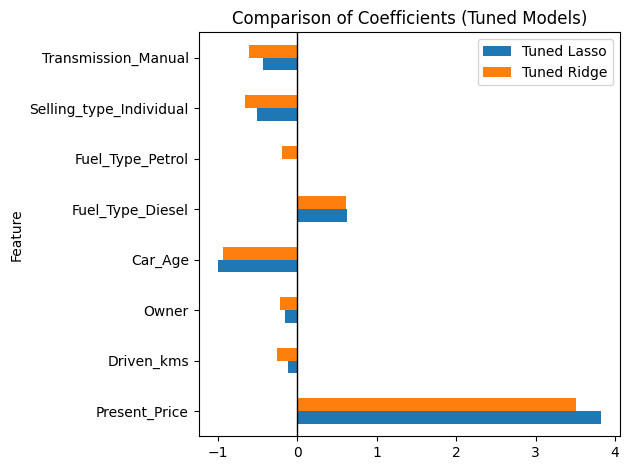

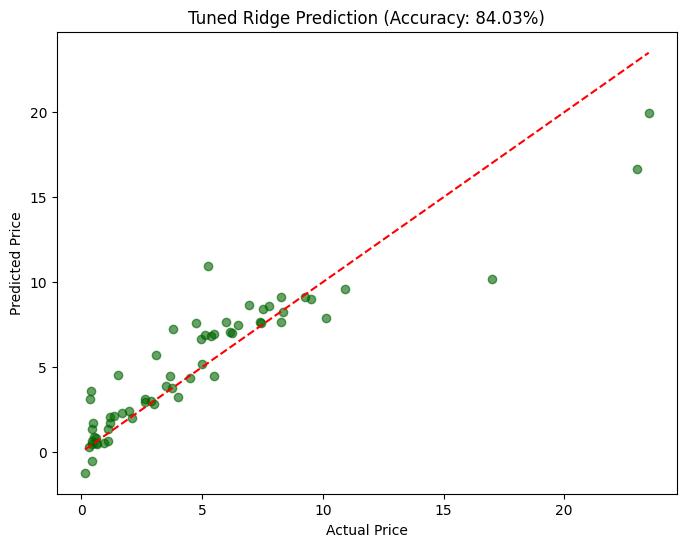

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv('car_data.csv')

# Preprocessing
current_year = 2024
df['Car_Age'] = current_year - df['Year']
df_model = df.drop(['Car_Name', 'Year'], axis=1)
df_model = pd.get_dummies(df_model, drop_first=True)

X = df_model.drop('Selling_Price', axis=1)
y = df_model['Selling_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Models
lr = LinearRegression().fit(X_train_scaled, y_train)
lasso_base = Lasso(alpha=1.0).fit(X_train_scaled, y_train)
ridge_base = Ridge(alpha=1.0).fit(X_train_scaled, y_train)

# Hyperparameter Tuning
alphas = np.logspace(-3, 2, 50)
grid_lasso = GridSearchCV(Lasso(), {'alpha': alphas}, cv=5, scoring='r2').fit(X_train_scaled, y_train)
grid_ridge = GridSearchCV(Ridge(), {'alpha': alphas}, cv=5, scoring='r2').fit(X_train_scaled, y_train)

best_lasso = grid_lasso.best_estimator_
best_ridge = grid_ridge.best_estimator_

# Evaluation function
def evaluate(model, X_t, y_t):
    preds = model.predict(X_t)
    r2 = r2_score(y_t, preds)
    return {
        'MAE': mean_absolute_error(y_t, preds),
        'MSE': mean_squared_error(y_t, preds),
        'R2': r2,
        'R2%': r2 * 100
    }

metrics = {
    'Linear Regression': evaluate(lr, X_test_scaled, y_test),
    'Lasso (Base)': evaluate(lasso_base, X_test_scaled, y_test),
    'Ridge (Base)': evaluate(ridge_base, X_test_scaled, y_test),
    'Lasso (Tuned)': evaluate(best_lasso, X_test_scaled, y_test),
    'Ridge (Tuned)': evaluate(best_ridge, X_test_scaled, y_test)
}

# Visualization 1: Feature Importance (Tuned Lasso vs Ridge)
plt.figure(figsize=(12, 6))
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Tuned Lasso': best_lasso.coef_,
    'Tuned Ridge': best_ridge.coef_
}).set_index('Feature')
coef_df.plot(kind='barh')
plt.title('Comparison of Coefficients (Tuned Models)')
plt.axvline(0, color='black', lw=1)
plt.tight_layout()
plt.savefig('car_coefficients.png')

# Visualization 2: Predicted vs Actual (Tuned Ridge)
plt.figure(figsize=(8, 6))
preds_ridge = best_ridge.predict(X_test_scaled)
plt.scatter(y_test, preds_ridge, alpha=0.6, color='darkgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Tuned Ridge Prediction (Accuracy: {metrics["Ridge (Tuned)"]["R2%"]:.2f}%)')
plt.savefig('car_tuned_performance.png')

print(pd.DataFrame(metrics).T)
print("\nBest Lasso Alpha:", grid_lasso.best_params_['alpha'])
print("Best Ridge Alpha:", grid_ridge.best_params_['alpha'])

*Hyperparameter Tuning (Grid Search Optimization)*

Optimal Lasso Alpha: 0.1207
Optimal Ridge Alpha: 14.5635


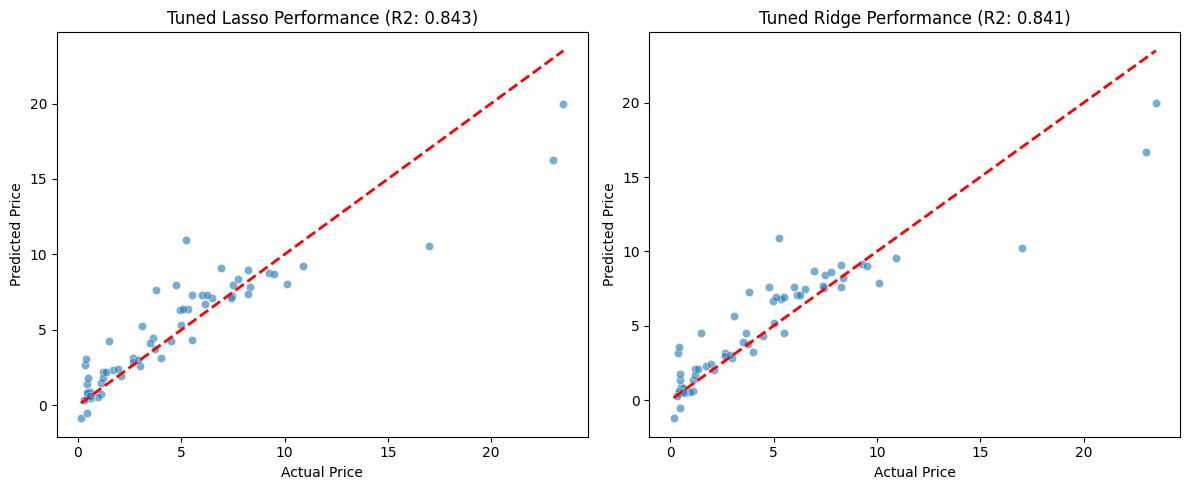

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Define Parameter Grid for Alpha
param_grid = {'alpha': np.logspace(-3, 3, 50)} # Testing 50 values from 0.001 to 1000

# 2. Lasso Hyperparameter Tuning
lasso_cv = GridSearchCV(Lasso(), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train_scaled, y_train)
best_lasso = lasso_cv.best_estimator_

# 3. Ridge Hyperparameter Tuning
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)
best_ridge = ridge_cv.best_estimator_

# 4. Final Performance Evaluation
tuned_preds = {
    "Tuned Lasso": best_lasso.predict(X_test_scaled),
    "Tuned Ridge": best_ridge.predict(X_test_scaled)
}

print(f"Optimal Lasso Alpha: {lasso_cv.best_params_['alpha']:.4f}")
print(f"Optimal Ridge Alpha: {ridge_cv.best_params_['alpha']:.4f}")

# 5. Visualization: Actual vs Predicted (Tuned Models)
plt.figure(figsize=(12, 5))

for i, (name, pred) in enumerate(tuned_preds.items(), 1):
    plt.subplot(1, 2, i)
    sns.scatterplot(x=y_test, y=pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
    plt.title(f"{name} Performance (R2: {r2_score(y_test, pred):.3f})")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")

plt.tight_layout()
plt.show()